# Graph Signal Processing examples

In this Notebook we will be looking into graph signal processing, a fast-growing field that deals with signals that are defined on the vertex set of weighted graphs. We will be using PyGSP, a Python package for graph signal processing operations.

## Set Up

In [1]:
#!pip install pygsp

In [2]:
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import scipy as sp
from pygsp import graphs, filters, plotting

In [3]:
plt.rcParams['figure.figsize'] = (13, 7)
tol = 1e-10
plotting.BACKEND = "matplotlib"

sns.set_style('darkgrid')
sns.set_palette('colorblind')

## Graph creation

In [4]:
communities = [100, 150, 80]
G = graphs.Community(N=330, Nc=3, comm_sizes=communities, seed=1)

2023-01-29 16:04:34,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 3.013793467093005


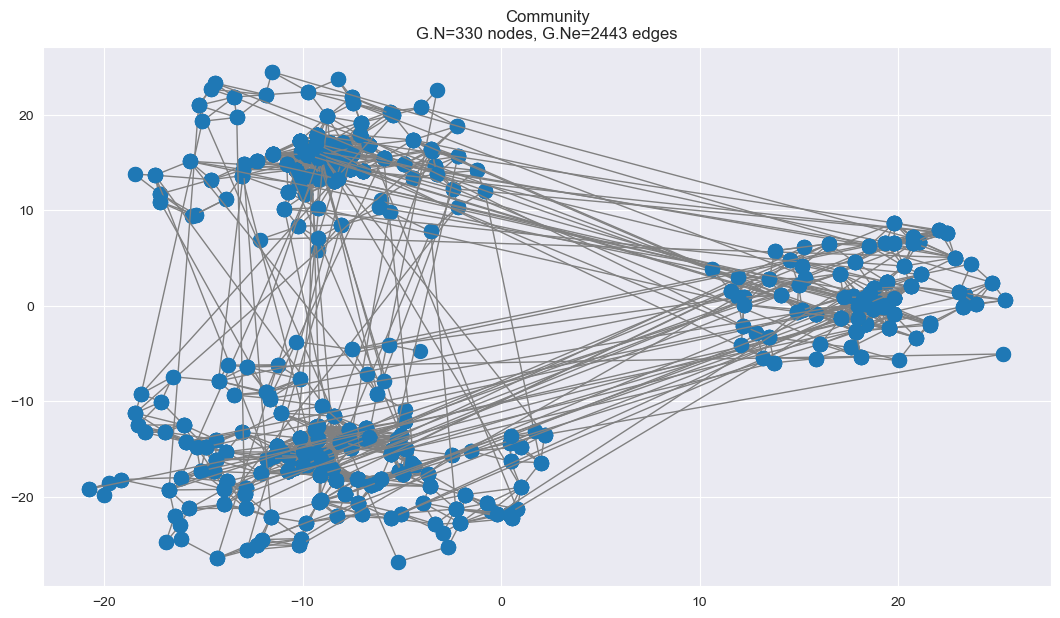

In [5]:
G.plot()

## Cluster detection

The unnormalised (combinatorial) graph Laplacian matrix is defined as:
$$L = D − A$$
where $D=(d_{ii})$ is the matrix that contains the degree of the nodes along diagonal and $A=(a_{ij})$ is the adjacency matrix. The laplacian can be used to detct clusters in the graph, in particular large gaps between the eigenvalues of the laplacian $\lambda_k$ and $\lambda_{k+1}$ heuristically appears when there is a strong structure in $k+1$ communities.

/Users/dany/opt/anaconda3/lib/python3.9/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


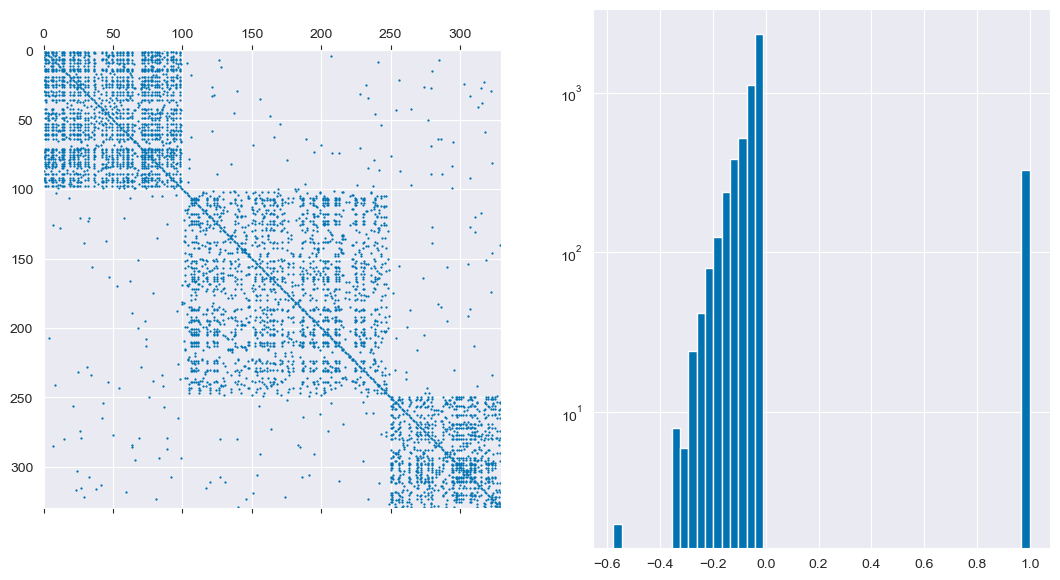

In [6]:
G.compute_laplacian('normalized')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6) #graph laplacian
axes[1].hist(G.L.data, bins=50, log=True);

Similar to the classical Fourier transform, the GFT transforms the graph signal from
the vertex domain into the graph spectral domain. Let us examine the Fourier coefficients of a random signal f on a
community graph, i.e., a graph in which nodes form a number of communities.

### Graph signals

A graph signal is a function $\mathcal{V} \rightarrow \mathbb{R}$ that associates a value to each node $v \in \mathcal{V}$ of a graph. The signal values can be represented as a vector $f \in \mathbb{R}^N$ where $N = |\mathcal{V}|$ is the number of nodes in the graph.

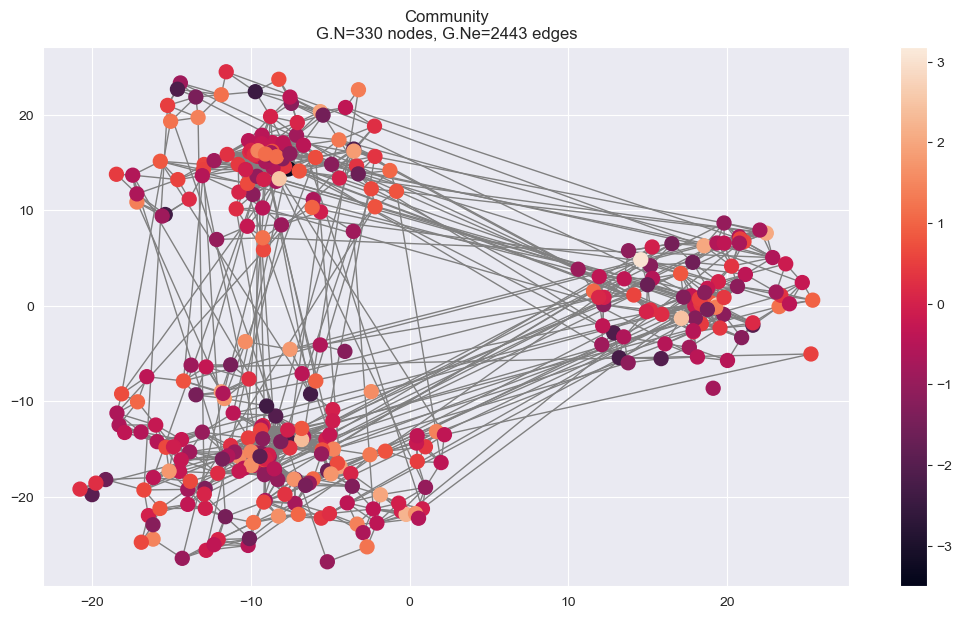

In [7]:
signal = np.random.normal(size=G.N)
G.plot_signal(signal)

### Smoothness

The smoothness of a signal can be computed by the quadratic form
$$ f^\intercal L f = \sum_{i \sim j} a_{ij} (f_i - f_j)^2 $$
The smaller the quantity $f^
TLf$, the smoother the signal on the graph (less variation of signal values across edges). Is the previous signal smooth?

In [8]:
signal.T @ G.L @ signal

370.0288031957278

In [9]:
signal.T @ G.L @ signal/ np.linalg.norm(signal)**2

1.0019864159101008

### Fourier transform

Similar to the classical Fourier transform, the GFT transforms the graph signal from
the vertex domain into the graph spectral domain. Let us examine the Fourier coefficients of a random signal $f$ on a
community graph.

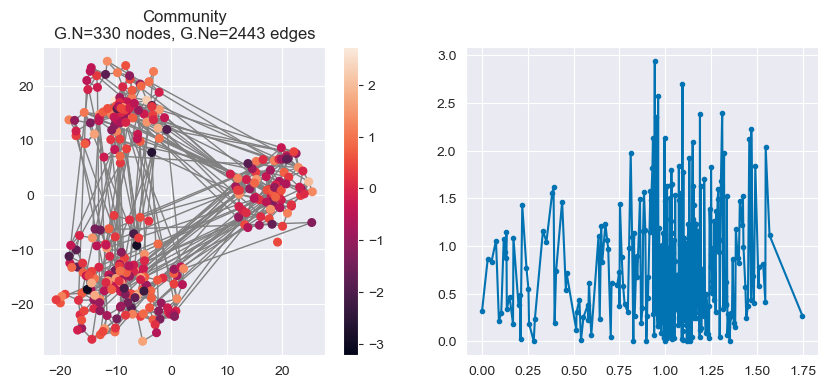

In [10]:
f = np.random.normal(size=G.N)
G.compute_fourier_basis()
f_hat = G.gft(f)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(f, vertex_size=30, ax=axes[0])
axes[1].plot(G.e, np.abs(f_hat), '.-')

### Filtering

Just like in classical signal processing, we can also apply filtering to graph signals. The main idea is to
transform the graph signal into the graph spectral domain, attenuate unwanted frequencies or amplify desired frequencies of the signal by modifying the corresponding Fourier coefficients, and convert the signal back to the vertex domain. This modification is done via a filter function $g(\lambda)$ in the graph spectral domain, where λ is the eigenvalue of the graph Laplacian. Let us start with the following an heat kernel filtering example, using the random signal $f$ and the community graph defined before.

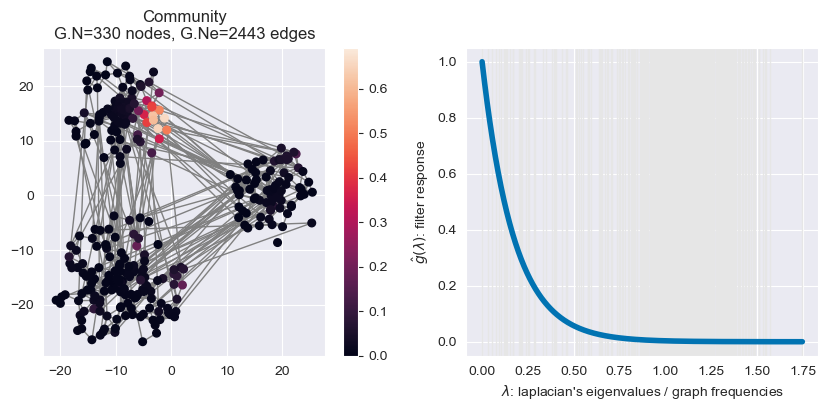

In [11]:
tau = 10
delta = 10
g = filters.Heat(G, tau) # the heat kernel defined via the graph spectral domain
s = g.localize(delta) # the heat kernel localised at a particular node in the vertex domain
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(s, vertex_size=30, ax=axes[0])
g.plot(ax=axes[1])

From the plot, you can see that in the graph spectral domain the filter penalises more the high frequencies (larger eigenvalues). This filter can be visualised in the vertex domain as well, by “localising” the heat kernel at a particular node. This corresponds to applying the filter to a graph signal that is a Kronecker delta function, i.e., having value 1 on the chosen node and 0 otherwise.

## Application: the "sound" of the Minnesota Road Network with a random signal.

In [12]:
G = graphs.Minnesota(365)
G.compute_fourier_basis()

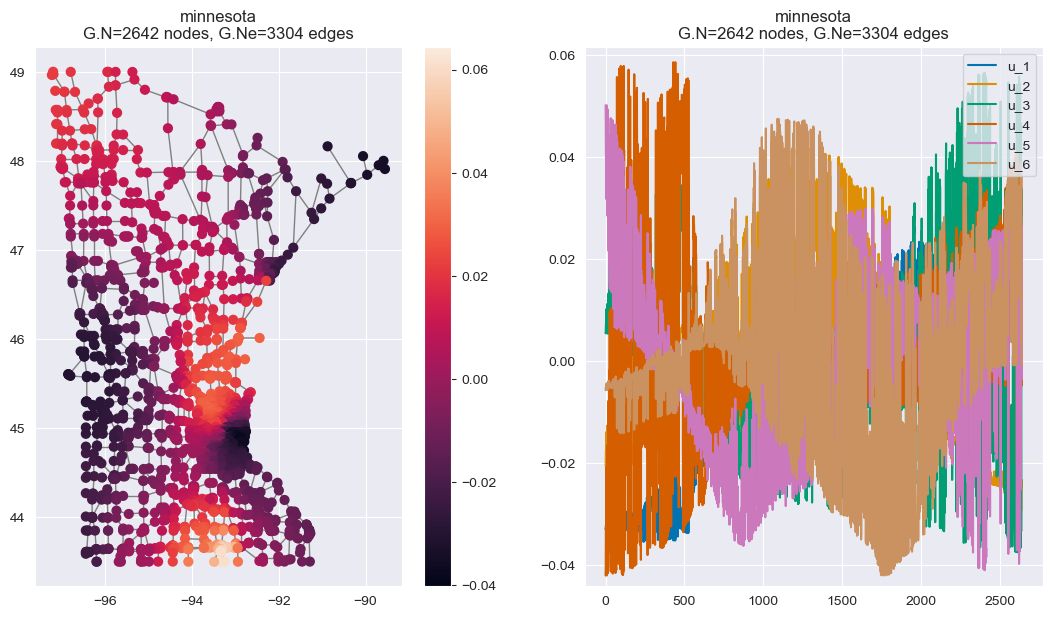

In [13]:
fig, axes = plt.subplots(1, 2)
G.plot_signal(G.U[:, 7], ax=axes[0])

# First 6 eigenvectors (signals)
G.set_coordinates('line1D')
G.plot_signal(G.U[:, 1:7], ax=axes[1])
axes[1].legend(['u_{}'.format(i) for i in range(1, 7)])